# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [29]:
!pip install dataclasses
!pip install matplotlib

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataclasses import dataclass

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

print('Observation shape', state.shape)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37
Observation shape (37,)


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [8]:
class ReplayBuffer:
    """
    Replay Buffer Implementation
    :arg [max_size]: buffer max size
    :arg [input_shape]: shape of trajectory
    :arg [n_actions]: number of actions allowed by the env
    """
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.randint(0, max_mem, size=batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [9]:
class DuelingDeepQNetworkMlp(nn.Module):
    """
    Duelling Deep Q-Net Implementation with MLP
    :arg [lr]: learning rate for the optimiser
    :arg [n_actions]: number of actions allowed by the env
    :arg [input_dims]: dimension for the conv net
    """
    def __init__(self, lr, n_actions, input_dims, fc1_dims=64, fc2_dims=64):
        super().__init__()

        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        
        # Create state value and action advantage value streams
        self.V = nn.Linear(fc2_dims, 1)
        self.A = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        flat1 = F.relu(self.fc1(state))
        flat2 = F.relu(self.fc2(flat1))
        V = self.V(flat2)
        A = self.A(flat2)

        # Combine state value and advantage value to get final action values
        actions = V + A - A.mean(dim=1, keepdim=True)
        return actions

In [10]:
class DuellingDeepQNetworkConv(nn.Module):
    """
    Duelling Deep Q-Net Implementation with Conv Nets
    :arg [lr]: learning rate for the optimiser
    :arg [n_actions]: number of actions allowed by the env
    :arg [input_dims]: dimension for the conv net
    """
    def __init__(self, lr, n_actions, input_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        # Create state value and action advantage value streams
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def save(self):
        T.save(
        {
            'q_eval_params': self.q_eval.state_dict(),
            'q_next_params': self.q_next.state_dict(),
            'eval_optim': self.q_eval.optimizer.state_dict(),
            'target_optim': self.q_next.optimizer.state_dict(),
            'epsilon': self.epsilon
            
        },
        './model.chkpt')

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv_state = conv3.view(conv3.size()[0], -1)

        flat1 = F.relu(self.fc1(conv_state))
        V = self.V(flat1)
        A = self.A(flat1)

        # Combine state value and advantage value to get final action values
        actions = V + A - A.mean(dim=1, keepdim=True)
        return actions

In [19]:
class DuellingDDQNAgent:
    def __init__(self, config):
        self.gamma = config.gamma
        self.epsilon = config.epsilon
        self.lr = config.lr
        self.n_actions = config.n_actions
        self.input_dims = config.input_dims
        self.batch_size = config.batch_size
        self.eps_min = config.eps_min
        self.eps_dec = config.eps_dec
        self.mem_size = config.mem_size
        self.replace_target_cnt = config.replace
        self.action_space = [i for i in range(self.n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(self.mem_size, self.input_dims, self.n_actions)

        self.q_eval = DuelingDeepQNetworkMlp(self.lr, self.n_actions,
                                    input_dims=self.input_dims)

        self.q_next = DuelingDeepQNetworkMlp(self.lr, self.n_actions,
                                    input_dims=self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                            self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done.astype(np.uint8)).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones


    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min
    
    def save(self):
        T.save(
        {
            'q_eval_params': self.q_eval.state_dict(),
            'q_next_params': self.q_next.state_dict(),
            'eval_optim': self.q_eval.optimizer.state_dict(),
            'target_optim': self.q_next.optimizer.state_dict(),
            'epsilon': self.epsilon
            
        },
        './model.pt')

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]

        with T.no_grad():
            q_next = self.q_next.forward(states_).max(dim=1)[0]
            q_next.masked_fill_(dones, 0.0)
            q_target = (rewards + self.gamma * q_next)
        
        loss = self.custom_mse_loss(q_pred, q_target).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()
    
    def custom_mse_loss(self, inpt, target):
        return (inpt - target).pow(2).mean()


In [20]:
@dataclass
class AgentConfig:
    n_actions: int 
    input_dims: tuple
    gamma: float
    epsilon: float
    lr: float
    mem_size: int
    batch_size: float
    eps_min: float
    eps_dec: float
    replace: int

In [25]:
def launcher(env, actions, episodes=100):
    env_info = env.reset(train_mode=True)[brain_name]
    observation_shape = env_info.vector_observations[0].shape
    
    agent_config = AgentConfig(
        n_actions=actions,
        input_dims=tuple(observation_shape),
        gamma=0.99,
        epsilon=1.0,
        lr=0.0001,
        mem_size=50000,
        batch_size=64,
        eps_min=0.05,
        eps_dec=1e-5,
        replace=1000,
    )
    
    agent = DuellingDDQNAgent(config=agent_config)
    
    scores = []
    best_score = -np.inf
    for episode in range(episodes):
        score = 0
        done = False
        env_info = env.reset(train_mode=True)[brain_name]
        observation = env_info.vector_observations[0]
        while not done:
            action = agent.choose_action(observation)
            env_info = env.step(action)[brain_name]
            observation_ = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            score += reward
            
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            
            observation = observation_
            
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        
        if avg_score > best_score:
            agent.save()
            best_score = avg_score
        
        print(f"Episode: {episode}, Best score: {best_score}, Avg score: {avg_score}")
    
    return scores

In [26]:
scores = launcher(env, actions=action_size, episodes=1_000)

Episode: 0, Best score: 1.0, Avg score: 1.0
Episode: 1, Best score: 1.0, Avg score: 0.0
Episode: 2, Best score: 1.0, Avg score: 0.0
Episode: 3, Best score: 1.0, Avg score: -0.25
Episode: 4, Best score: 1.0, Avg score: 0.0
Episode: 5, Best score: 1.0, Avg score: -0.16666666666666666
Episode: 6, Best score: 1.0, Avg score: -0.14285714285714285
Episode: 7, Best score: 1.0, Avg score: 0.0
Episode: 8, Best score: 1.0, Avg score: 0.0
Episode: 9, Best score: 1.0, Avg score: 0.1
Episode: 10, Best score: 1.0, Avg score: 0.09090909090909091
Episode: 11, Best score: 1.0, Avg score: 0.16666666666666666
Episode: 12, Best score: 1.0, Avg score: 0.07692307692307693
Episode: 13, Best score: 1.0, Avg score: 0.14285714285714285
Episode: 14, Best score: 1.0, Avg score: 0.2
Episode: 15, Best score: 1.0, Avg score: 0.125
Episode: 16, Best score: 1.0, Avg score: 0.11764705882352941
Episode: 17, Best score: 1.0, Avg score: 0.2222222222222222
Episode: 18, Best score: 1.0, Avg score: 0.15789473684210525
Episod

In [27]:
np.save('scores.npy', scores)

In [30]:
import matplotlib.pyplot as plt

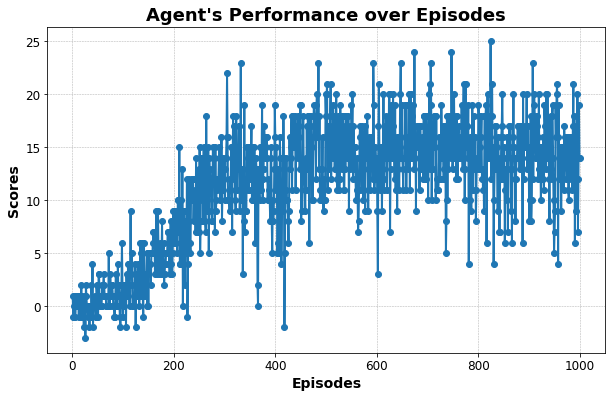

In [31]:
def plot_scores(scores, output_file=None):
    episodes = len(scores)
    x = np.arange(1, episodes + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(x, scores, linewidth=2, marker='o', markersize=6, linestyle='-')

    plt.title("Agent's Performance over Episodes", fontsize=18, fontweight='bold')
    plt.xlabel('Episodes', fontsize=14, fontweight='bold')
    plt.ylabel('Scores', fontsize=14, fontweight='bold')

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    else:
        plt.show()

plot_scores(scores, output_file='agent_performance_plot.png')

In [32]:
env.close()